In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - \ done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 12.9 GB  I Proc size: 138.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
!pip install torch torchvision tensorboardX

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a432000 @  0x7fb7b00d82a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 21.3MB/s 
    100% |████████████████████████████████| 2.0MB 4.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [4]:
for i in range(cuda.device_count()):
    print(cuda.get_device_name(i))

Cuda is avaulable: True
Tesla K80


In [5]:
from google.colab import files
uploaded = files.upload()

Saving data.zip to data.zip


In [6]:
!ls

data.zip  sample_data


In [0]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import pickle
import os
import random
from collections import defaultdict
import itertools
from timeit import default_timer as timer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [9]:
!tar -xzvf skipgramstate.tar.gz

['Archive:  data.zip',
 '   creating: data/',
 '  inflating: data/nice_embed_tsne.csv  ',
 '  inflating: data/acid_properties.csv  ',
 '  inflating: data/family_classification_sequences.tab  ',
 '  inflating: data/family_classification_metadata.tab  ']

In [10]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [0]:
counter = itertools.count()
cod2id = defaultdict(lambda: next(counter))

def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cod2id[cropped_seq[i:i+3]] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [0]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [86]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [87]:
!ls -lh data

total 559M
-rw-rw-r-- 1 root root  563 Aug  2  2017 acid_properties.csv
-rw-r--r-- 1 root root 394M Oct 14 15:50 all_codones.pickle
-rw-rw-r-- 1 root root  32M Aug  3  2017 family_classification_metadata.tab
-rw-rw-r-- 1 root root 133M Aug  3  2017 family_classification_sequences.tab
-rw-rw-r-- 1 root root 398K Aug  2  2017 nice_embed_tsne.csv


In [0]:
######################

In [0]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target

def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = torch.zeros(batch_size, dtype=torch.long)
        target_batch = torch.zeros(batch_size, dtype=torch.long)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch.cuda(), target_batch.cuda()

def flatten(x):
    return [item for sublist in x for item in sublist]

def count_codones(all_codones):
    return np.bincount(flatten(all_codones))

def process_data(all_codones, batch_size, skip_window):
    single_gen = generate_sample(all_codones, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [0]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

random.seed(117)  # to reproduce batches
batch_gen = process_data(all_codones, BATCH_SIZE, SKIP_WINDOW)

In [0]:
######################

In [0]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.embed_aux = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, in_words, out_words, sampled_words):
        in_words = self.embed(in_words)
        out_words = self.embed_aux(out_words)
        sampled_words = self.embed_aux(sampled_words)
        
        # batch dot product; torch.bmm is said to be slower for this task
        losses = F.logsigmoid((in_words * out_words).sum(dim=1))
        sampled_losses = F.logsigmoid(torch.bmm(-sampled_words,
                                                in_words.unsqueeze(-1))
                                      .squeeze(dim=2)).sum(dim=1)
        
        return -(losses + sampled_losses).mean()

In [0]:
######################

In [0]:
p = np.array(count_codones(all_codones))
p = p**0.75
p /= p.sum()

def neg_sample(size):
    return np.random.choice(len(cod2id), size=size, p=p)

In [0]:
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .05
N_STEPS = 200000
N_DEBUG_OUTPUT_STEPS = N_STEPS / 100
START_STEP = 0

def train(model, optimizer, batch_gen):
    start_t
    writer = SummaryWriter()
    for t, batch in itertools.islice(enumerate(batch_gen,
                                               START_STEP,
                                               START_STEP + N_STEPS)):
        in_words, out_words = batch
        sampled_words = in_words.new_tensor(
            neg_sample((*in_words.size(), NUM_SAMPLED)))
        
        optimizer.zero_grad()
        loss = model(in_words, out_words, sampled_words)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Loss', -loss, t)
        if (t + 1) % N_DEBUG_OUTPUT_STEPS == 0:
            print('Step {}, current loss is {:.3f}, time spent: {:.3f} seconds'
                  .format(t + 1, -loss.item(), timer() - start_time))
    writer.add_text(('Learning finished in {:.3f} seconds from step {}' + 
                     'to step {}')
                    .format(timer() - start_time, START_STEP, N_STEPS))
    writer.add_embedding(model.embed.weight)
    
    writer.close()

In [94]:
model = SkipGram(len(cod2id), EMBED_SIZE)
if os.file.exists('models/model_{}.pth'.format(START_STEP)):
    model.load_state_dict(torch.load('models/model_{}.pth'.format(START_STEP)))
model = model.cuda()
train(model, torch.optim.SGD(model.parameters(), lr=LEARNING_RATE), batch_gen)

Step 200, current loss is -25.128
Step 400, current loss is -25.751
Step 600, current loss is -24.918
Step 800, current loss is -21.015
Step 1000, current loss is -21.353
Step 1200, current loss is -21.540
Step 1400, current loss is -22.941
Step 1600, current loss is -19.008
Step 1800, current loss is -23.972
Step 2000, current loss is -20.386
Step 2200, current loss is -12.285
Step 2400, current loss is -21.001
Step 2600, current loss is -18.526
Step 2800, current loss is -19.587
Step 3000, current loss is -18.453
Step 3200, current loss is -19.073
Step 3400, current loss is -18.826
Step 3600, current loss is -15.423
Step 3800, current loss is -13.251
Step 4000, current loss is -14.536
Step 4200, current loss is -10.472
Step 4400, current loss is -14.600
Step 4600, current loss is -9.142
Step 4800, current loss is -17.951
Step 5000, current loss is -10.622
Step 5200, current loss is -11.428
Step 5400, current loss is -6.872
Step 5600, current loss is -4.880
Step 5800, current loss is 

KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(), 'models/model_{}.pth'.format(START_STEP + N_STEPS))

In [144]:
# Serialization
!ls  -lh
!tar -czvf skipgramstate.tar.gz data runs models

total 38M
drwxrwxr-x 2 root root 4.0K Oct 14 17:54 data
-rw-r--r-- 1 root root  38M Oct 14 15:31 data.zip
drwxr-xr-x 2 root root 4.0K Oct 14 18:07 models
drwxr-xr-x 2 root root 4.0K Oct 12 16:10 sample_data
data/
data/acid_properties.csv
data/family_classification_metadata.tab
data/all_acid_dicts.pickle
data/all_codones.pickle
data/nice_embed_tsne.csv
data/family_classification_sequences.tab
runs/
models/
models/model_200000.pth


In [0]:
files.download('skipgramstate.tar.gz')

In [95]:
print(model.embed.weight)

Parameter containing:
tensor([[-0.1800,  0.1754, -0.0476,  ...,  0.8485,  0.5983,  0.8105],
        [ 0.4024,  0.0260,  0.0629,  ..., -0.0609, -0.1083, -0.2544],
        [ 0.1891,  0.0291,  0.1107,  ..., -0.2362, -0.1521,  0.1939],
        ...,
        [ 0.8879,  1.4575,  0.7101,  ..., -0.2266,  0.8946,  1.1521],
        [ 0.5520, -1.9382,  0.6778,  ...,  0.1756,  0.0216,  0.1315],
        [ 1.2178,  0.1222,  0.6693,  ..., -0.4740, -1.4893, -0.1586]],
       device='cuda:0', requires_grad=True)


In [0]:
######################


In [120]:
from timeit import default_timer as timer
with torch.no_grad():
    st = timer()
    tsne = TSNE(n_components=2, random_state=42)
    XX = tsne.fit_transform(model.embed.weight)
    print('t-SNE finished in {:.3f} seconds'.format(timer() - st))

370.613


In [121]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(cod2id, key=cod2id.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0         x1 codone
0  18.055569 -27.160341    MAF
1   5.180469 -16.614149    SAE
2  -0.556969   3.848840    DVL
3  -2.694185  -8.073409    KEY
4  -1.004901 -21.737244    DRR

In [0]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

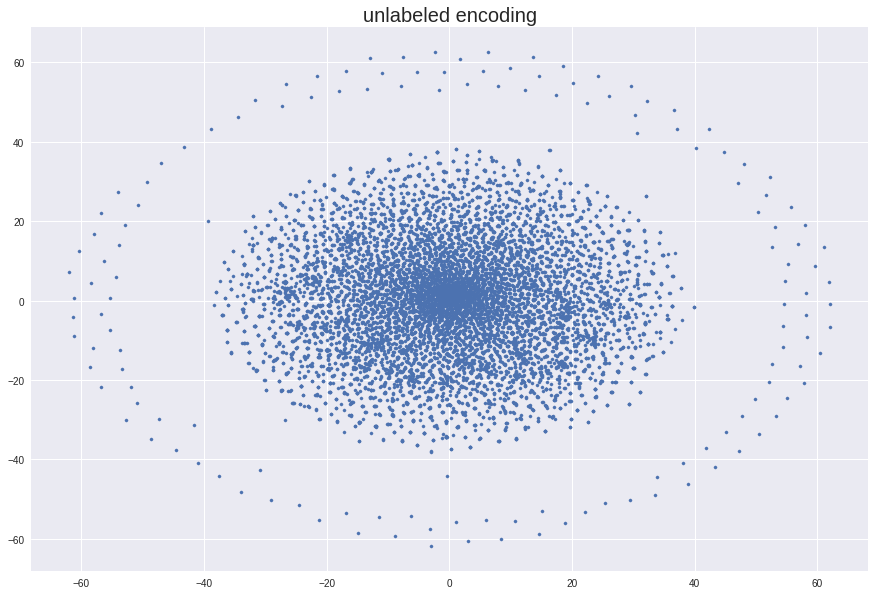

In [123]:
plot_tsne_df(tsne_df)

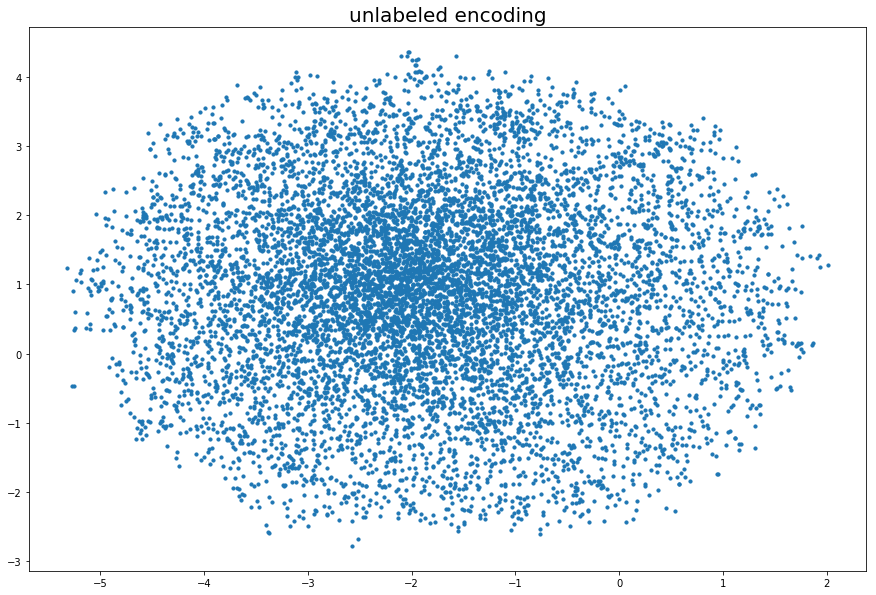

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_tsne_df(tsne_df)

In [0]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [0]:
######################

In [0]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [129]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [130]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  MAF        2.166667  116.482633        18.666667  147.133333
1  SAE       -0.833333   95.756400        15.333333  105.333333
2  DVL        1.500000  109.125367        19.000000  139.266667
3  KEY       -2.900000  140.153200        22.333333  166.866667
4  DRR       -4.166667  142.486267        22.666667  152.633333

In [131]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume         x0  \
0  MAF        2.166667  116.482633        18.666667  147.133333  18.055569   
1  SAE       -0.833333   95.756400        15.333333  105.333333   5.180469   
2  DVL        1.500000  109.125367        19.000000  139.266667  -0.556969   
3  KEY       -2.900000  140.153200        22.333333  166.866667  -2.694185   
4  DRR       -4.166667  142.486267        22.666667  152.633333  -1.004901   

          x1  
0 -27.160341  
1 -16.614149  
2   3.848840  
3  -8.073409  
4 -21.737244

In [0]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

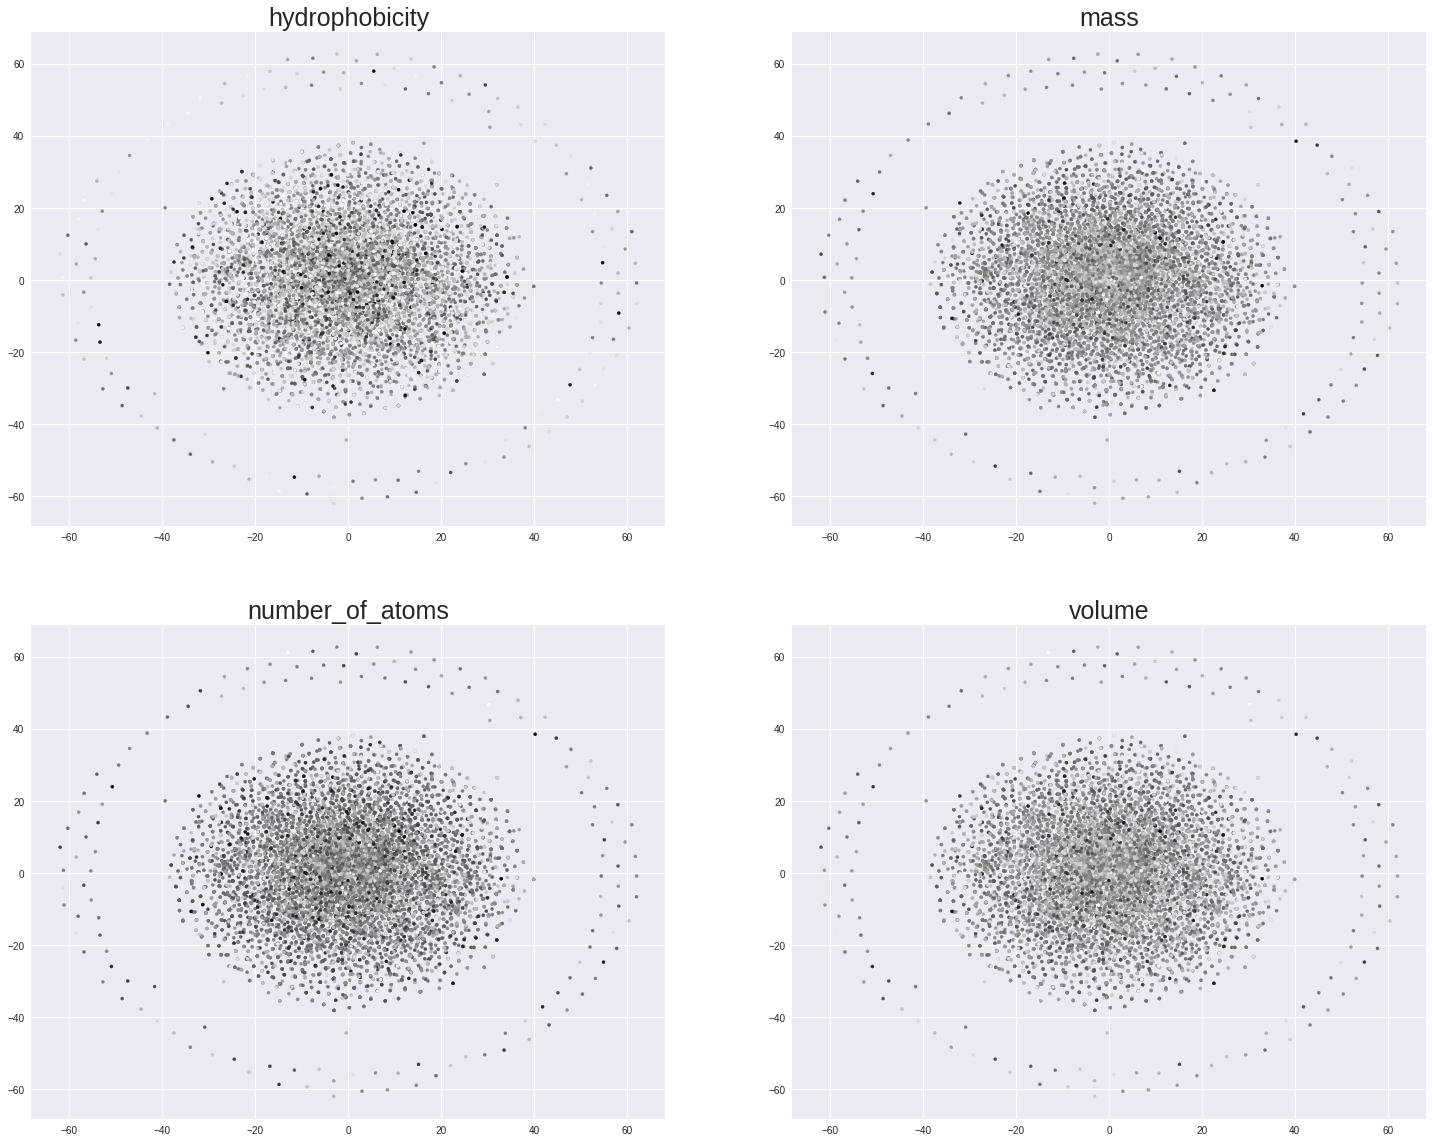

In [133]:
plot_embedding_properties(final_df)

# End of homework
================================

In [138]:
!ls

data  data.zip	sample_data


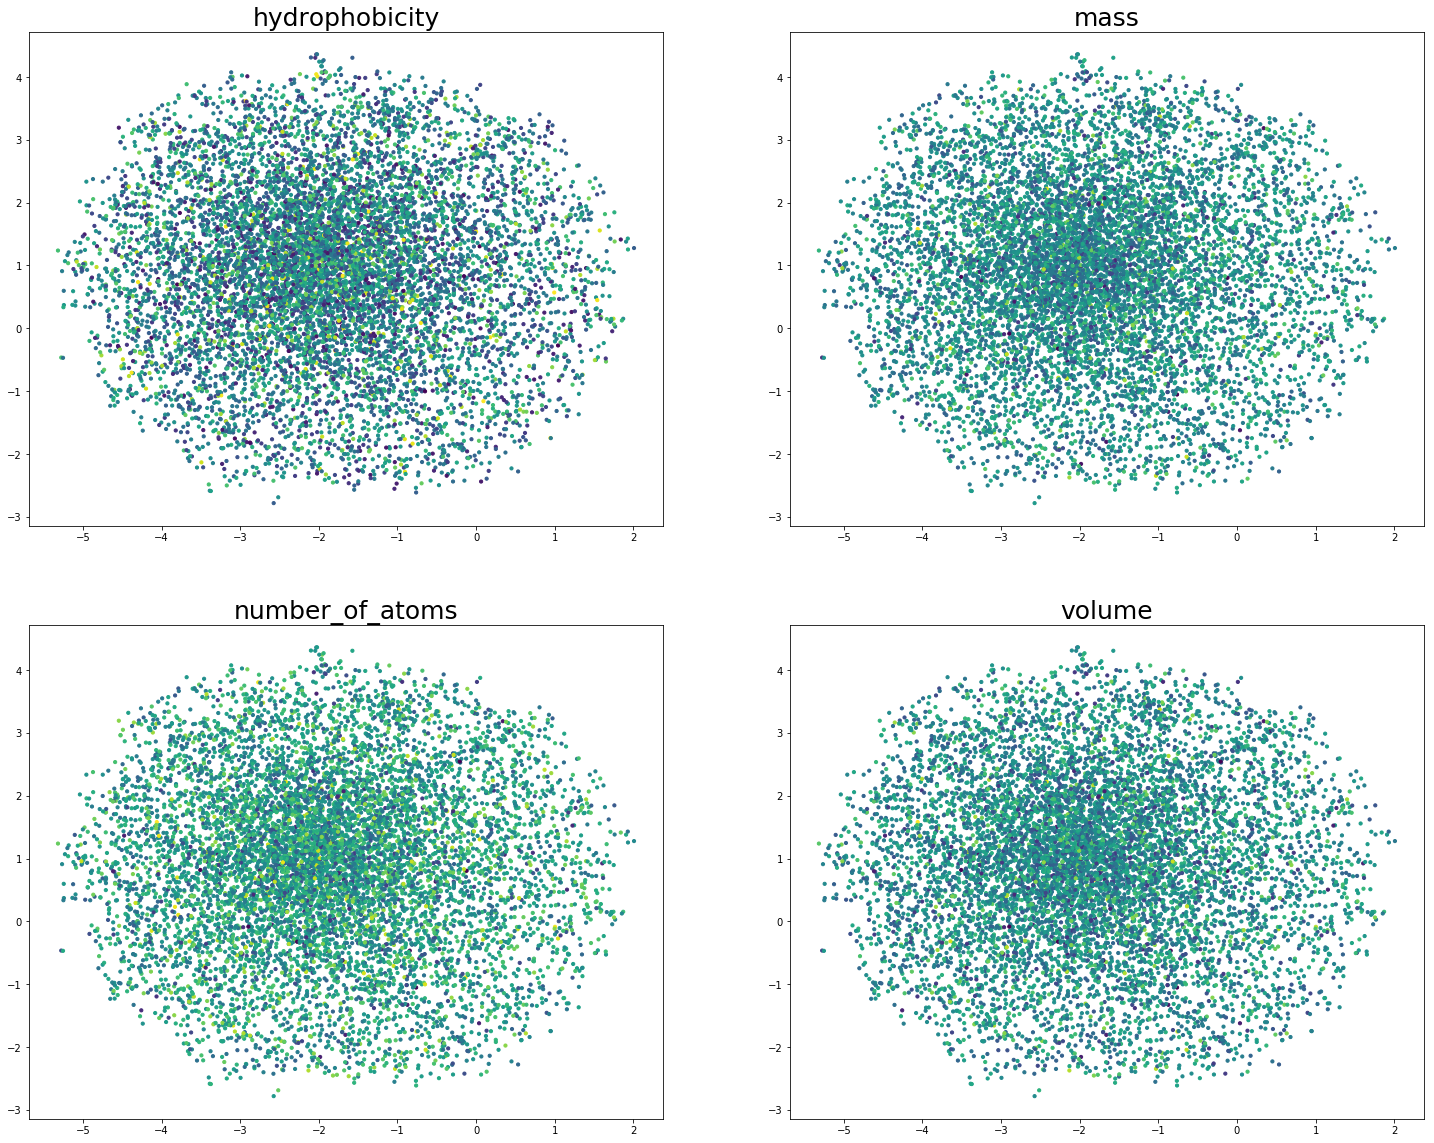

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_embedding_properties(final_df)

In [0]:
######################

In [0]:
# OLD, LEFT FOR COMPARISON
# filename = 'data/nice_embed_tsne.csv'
# gensim_tsne_df = pd.read_csv(filename, index_col=0)
# gensim_tsne_df.columns = ['x0', 'x1', 'codone']

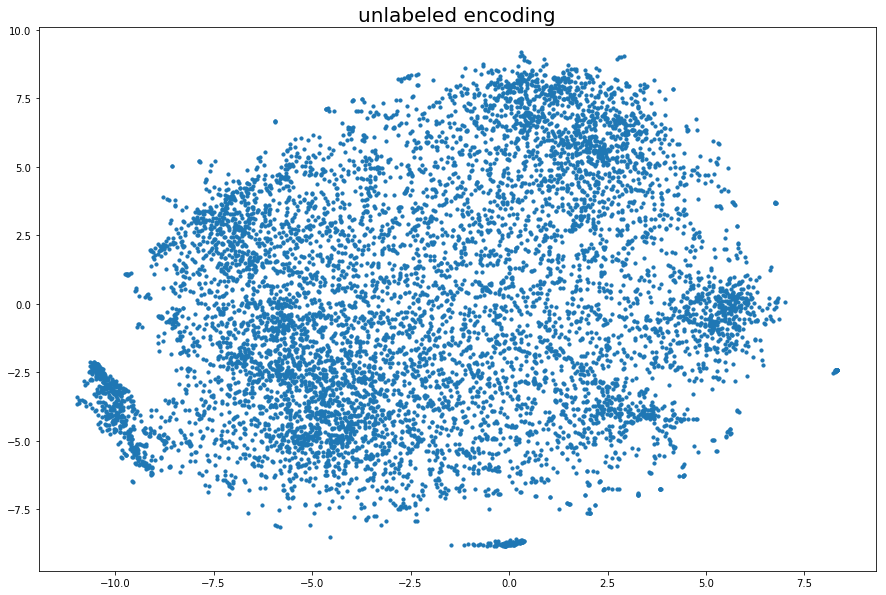

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_tsne_df(gensim_tsne_df)

In [0]:
# OLD, LEFT FOR COMPARISON
# final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

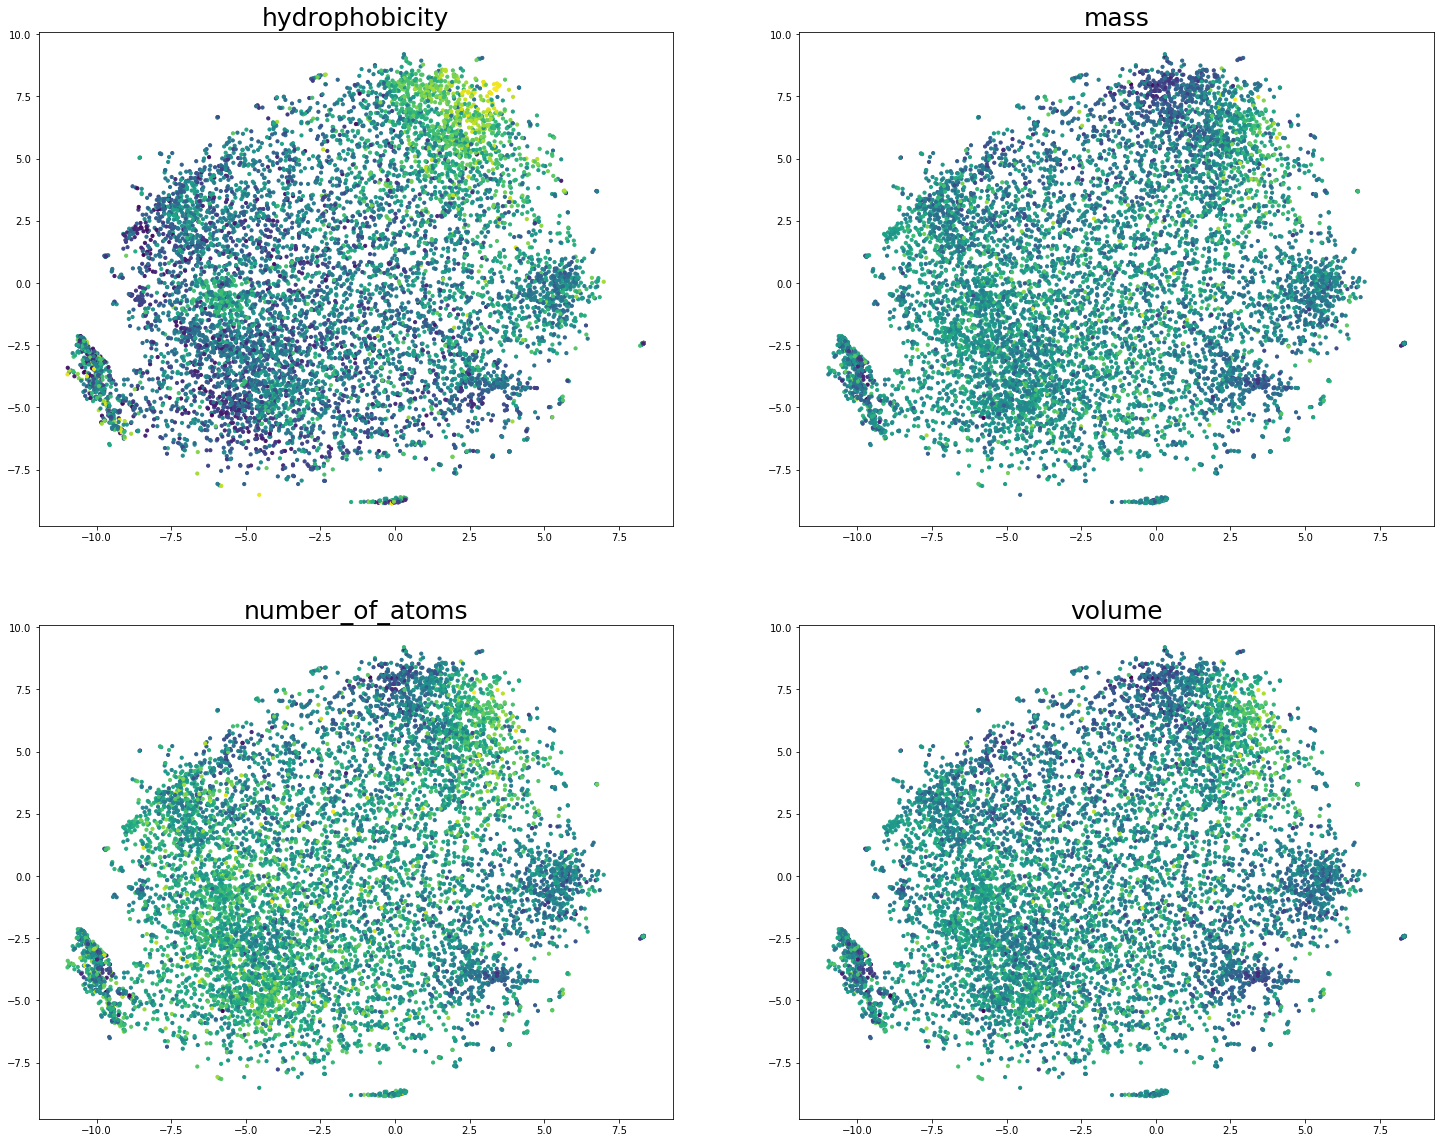

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [0]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59